# Initiate passive tracers and read their information 
Passive tracers are useful to track the evolutions of the temperature, pressure and their spatial positions of moving materials during the simulation. Passive tracers can be initiated when you start a new model, and they are the Lagrangian points that move with the materials. The initiation and extraction of information from passive tracers can be easily done using the following methods.

### Initiate passive tracers in the model
Let's use a simple model of a "falling sphere" as the example. We initiate the passive tracer by turning on the flag: `Passive_Tracer=1` and assign a spatial range to populate tracers in the entire simulation box `PassiveTracer_Box=[-1,1,-1,1,-1,1])`. The default tracer density is 100 x 1 x 100 along x, y, z axes. 

In [1]:
using LaMEM, GeophysicalModelGenerator, Plots

model  = Model(Grid(nel=(16,16,16), x=[-1,1], y=[-1,1], z=[-1,1]), PassiveTracers(Passive_Tracer=1, PassiveTracer_Box=[-1,1,-1,1,-1,1]))
matrix = Phase(ID=0,Name="matrix",eta=1e20,rho=3000)
sphere = Phase(ID=1,Name="sphere",eta=1e23,rho=3200)
add_phase!(model, sphere, matrix)
add_sphere!(model,cen=(0.0,0.0,0.0), radius=(0.5,))

run_lamem(model,1)

Saved file: Model3D.vts
Writing LaMEM marker file -> ./markers/mdb.00000000.dat
cores_compute = 1
-------------------------------------------------------------------------- 
                   Lithosphere and Mantle Evolution Model                   
     Compiled: Date: Jan  1 1970 - Time: 00:00:00 	    
     Version : 2.1.4 
-------------------------------------------------------------------------- 
        STAGGERED-GRID FINITE DIFFERENCE CANONICAL IMPLEMENTATION           
-------------------------------------------------------------------------- 
Parsing input file : output.dat 
Finished parsing input file 
--------------------------------------------------------------------------
Scaling parameters:
   Temperature : 1000. [C/K] 
   Length      : 2000. [m] 
   Viscosity   : 1e+20 [Pa*s] 
   Stress      : 1e+07 [Pa] 
--------------------------------------------------------------------------
Time stepping parameters:
   Simulation end time          : 1. [Myr] 
   Maximum number of s

### Read passive tracers information back to Julia
We can check the overall passive tracers information at timestep = 0 using:

In [2]:
data,time = read_LaMEM_timestep(model, 0, passive_tracers=true)

(CartData 
    size    : (10000,)
    x       ϵ [ -0.99 : 0.99]
    y       ϵ [ 0.0 : 0.0]
    z       ϵ [ -0.99 : 0.99]
    fields  : (:Phase, :Temperature, :Pressure, :ID)
, [0.0])

The `data.x`, `data.y`, and `data.z` are structures that contain spatial information of tracers while parameters such like `data.fields.Phase` contain the phase, temperature, pressure and index (ID) of tracers.

Sometime we want to select tracers in a smaller region for further investigation. For example, to track the P-T-t evolution of a subducting slab, we can specify a region of interest (e.g., the upper crust portion of the slab) therefore select tracers within that region only.

In the "falling sphere" example, let's find all the "sphere phase" tracers in the 1st quadrant (x>0, and z>0) of the sphere.

In [3]:
ID = findall(data.x.val .> 0 .&& data.z.val .> 0 .&& data.fields.Phase .== 1)

489-element Vector{Int64}:
 5051
 5052
 5053
 5054
 5055
 5056
 5057
 5058
 5059
 5060
    ⋮
 7354
 7355
 7356
 7451
 7452
 7453
 7454
 7455
 7456

The `ID` parameter records the indices of these tracers. Note we need to do `data.x.val` to get the numerical value of the x-coordinate because `data.x` is a structure also containing `unit`, and `isdimensional` information. The dot in front of `>` and `&&`  implies that it is applied to every point the array data.

Once we select the tracers of interest (we now know the ID of these tracers), we can read their information.

In [4]:
passive_tracers = passivetracer_time(ID,model)

(x = [0.029999999329447746 0.0300015676766634 … 0.02996705286204815 0.029961101710796356; 0.05000000074505806 0.050001565366983414 … 0.04996703565120697 0.04996108263731003; … ; 0.10999999940395355 0.1100161224603653 … 0.11005415767431259 0.11005589365959167; 0.12999999523162842 0.13001509010791779 … 0.13003657758235931 0.13003596663475037], y = [0.0 1.5680611795687582e-6 … -3.293123154435307e-5 -3.8880683860043064e-5; 0.0 1.5680224123570952e-6 … -3.2937077776296064e-5 -3.8887312257429585e-5; … ; 0.0 1.646793680265546e-5 … 7.543351966887712e-5 8.05598174338229e-5; 0.0 1.5884716049185954e-5 … 7.381262548733503e-5 7.891751738497987e-5], z = [0.009999999776482582 0.00966682005673647 … 0.002956063486635685 0.001930731232278049; 0.009999999776482582 0.009666140191257 … 0.0029512858018279076 0.0019254740327596664; … ; 0.49000000953674316 0.48966488242149353 … 0.4829537868499756 0.4819290041923523; 0.49000000953674316 0.4896642863750458 … 0.48295098543167114 0.48192599415779114], Phase = [1.0

Let's take a look at the `passive_tracers`, and see what information it contains. Run the cell below:

In [5]:
# Retrieve the keys from the passive_tracers
keys_list = keys(passive_tracers)

# Iterate over each key and print the size of the associated data
for key in keys_list
    data_size = size(passive_tracers[key])
    println("Key: $key, Size: $data_size")
end

Key: x, Size: (489, 14)
Key: y, Size: (489, 14)
Key: z, Size: (489, 14)
Key: Phase, Size: (489, 14)
Key: Temperature, Size: (489, 14)
Key: Pressure, Size: (489, 14)
Key: Time_Myrs, Size: (14,)


The `passive_tracers` contains spatial cooridiates and P, T, Phase properties and also the assocated temporal information for all 4 time steps in matrixes. Now let's plot the position of selected tracer at t=0.

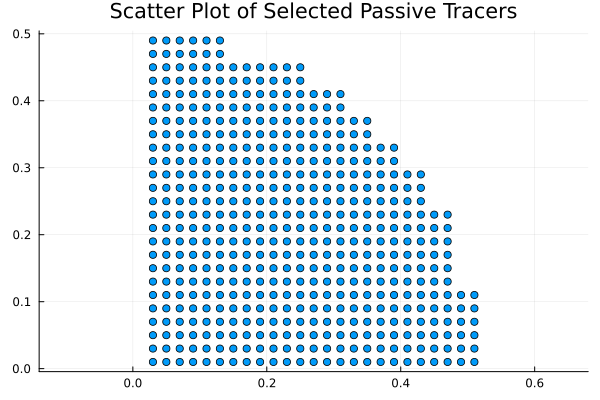

In [6]:
using Plots
scatter(passive_tracers.x[:,1], passive_tracers.z[:,1], title="Scatter Plot of Selected Passive Tracers", legend=false, aspect_ratio=:equal)

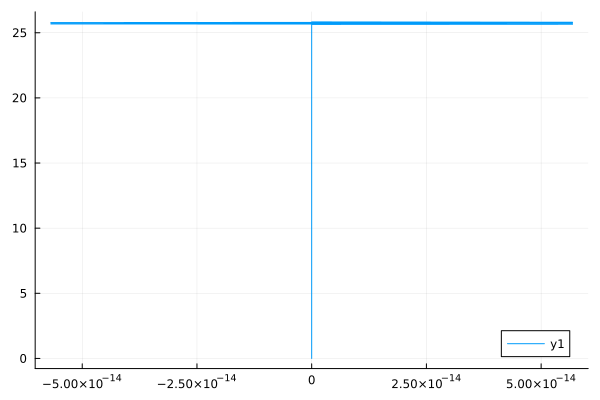

In [7]:
plot( passive_tracers.Temperature[1,:], passive_tracers.Pressure[1,:])

 Since the example "falling sphere" code does not contain much dynamics and it only runs for a few timesteps, the resulted P-T path contain little information. 

It is also doable to plot the the average P, T properties of a small group of tracers of our selection.